In [1]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` 
    # function in the annotation defines how this state should 
    # be updated (in this case, it appends new messages to the 
    # list, rather than replacing the previous messages)
	messages: Annotated[list, add_messages]

builder = StateGraph(State)

In [4]:
from langchain_ollama import ChatOllama

model = ChatOllama(
    base_url="http://localhost:11434", model="qwen2.5:32b", temperature=0
)

def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}

# The first argument is the unique node name 形参1：节点名称
# The second argument is the function or Runnable to run 形参2:需要跑的函数或Runnable
builder.add_node("chatbot", chatbot)

In [5]:
builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)

graph = builder.compile()

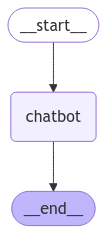

In [6]:
graph

In [7]:
graph.get_graph().draw_mermaid_png()

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00k\x00\x00\x00\xea\x08\x02\x00\x00\x00*1,&\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x16\xdfIDATx\x9c\xed\x9d{`\x13U\xba\xc0O2I\x9aw\x9a&m\xfa~S\xfa\xa4 \x05\x01\x0b-\xb6<--\xb5\n\x02e\x01\x95\x95\xa5\xcb\xee\xbd\xb8+\xbb+.\xb8^\xb9\xdc\x8a.\xf7\xae\xab\xec]\x8a\xaePEX\x05\xac"\x05\x85"o\xa8<l\xe9\x8b\xbe\xe9\x83\xb6y\xbf_\x93\xdc?\xc2\xad,M2\x93NBN\xeb\xfc\xfe\xeb\xcc\x9c\xe9\x97_\xceL\xce\x9cs\xe6|\x14\xbb\xdd\x0eH\x08@\xf5w\x00c\x1e\xd2 QH\x83D!\r\x12\x854H\x14\xd2 Qh\x04\xcbk\xe4\x16\x95\xcc\xa2\xd7\xa0z5j\xb5\xd8m\xb61\xd06Bh\x80F\xa3\xb2\xf9\x08\x9bG\x13\x86\xd2\xd9\\B\x12(\xa3k\x0f\xca\xfaMm?\xe8:\xeat\x0c6\x05\xd8)l\x1e\xc2\xe6#,\x0e\xcd\x86\x8e\x01\x834:E\xab\xb6\xea\xd5\xa8^c5\x19lt\x065>\x83\x93\x98\xc9\xe5\x8b\xe8\xa38\x9b\xc7\x06\xb5J\xeb\xc5*\xa9\x1d\x80@1=.\x83\x13\x12\xc9\x1c\xc5\x7f\x85\x8a\xfe\x0eC{\x9dN1`\xe6\ni\xb3\n\xc4\x0c\xa6gw6\xcf\x0c^;)\xaf\xbf\xa8\x9a\xb5D<q*\xcf\xf3Pa\xa7\xee\xbc\xea\xe2\x97\xd2\x19O\x892

In [8]:
from langchain_core.messages import HumanMessage

In [9]:
input = {"messages": [HumanMessage('hi!')]}
for chunk in graph.stream(input):
    print(chunk)

{'chatbot': {'messages': [AIMessage(content='Hello! How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything specific.', additional_kwargs={}, response_metadata={'model': 'qwen2.5:32b', 'created_at': '2025-03-05T16:49:09.279574Z', 'done': True, 'done_reason': 'stop', 'total_duration': 9493749166, 'load_duration': 561253541, 'prompt_eval_count': 31, 'prompt_eval_duration': 7371000000, 'eval_count': 29, 'eval_duration': 1391000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-2226a224-c9be-469c-a7fc-2650b369d8e2-0', usage_metadata={'input_tokens': 31, 'output_tokens': 29, 'total_tokens': 60})]}}


## Adding Memory to StateGraph

In [10]:
from langgraph.checkpoint.memory import MemorySaver

graph = builder.compile(checkpointer=MemorySaver())

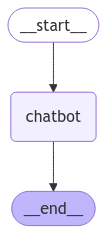

In [11]:
graph

In [12]:
thread1 = {"configurable": {"thread_id": "1"}}
result_1 = graph.invoke(
    { "messages": [HumanMessage("hi, my name is Jack!")] }, 
    thread1
)

In [13]:
result_1

{'messages': [HumanMessage(content='hi, my name is Jack!', additional_kwargs={}, response_metadata={}, id='17ecb8ee-617b-4bdf-8cfb-7e7185c9de64'),
  AIMessage(content="Hello Jack! It's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'qwen2.5:32b', 'created_at': '2025-03-05T17:08:21.098452Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2310243916, 'load_duration': 556787750, 'prompt_eval_count': 36, 'prompt_eval_duration': 748000000, 'eval_count': 18, 'eval_duration': 831000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-66282365-97a1-4c1b-a22c-f28b9816f99d-0', usage_metadata={'input_tokens': 36, 'output_tokens': 18, 'total_tokens': 54})]}

In [14]:
result_2 = graph.invoke(
    { "messages": [HumanMessage("what is my name?")] }, 
    thread1
)
result_2

{'messages': [HumanMessage(content='hi, my name is Jack!', additional_kwargs={}, response_metadata={}, id='17ecb8ee-617b-4bdf-8cfb-7e7185c9de64'),
  AIMessage(content="Hello Jack! It's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'qwen2.5:32b', 'created_at': '2025-03-05T17:08:21.098452Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2310243916, 'load_duration': 556787750, 'prompt_eval_count': 36, 'prompt_eval_duration': 748000000, 'eval_count': 18, 'eval_duration': 831000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-66282365-97a1-4c1b-a22c-f28b9816f99d-0', usage_metadata={'input_tokens': 36, 'output_tokens': 18, 'total_tokens': 54}),
  HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='5f425b83-efc8-44bb-ae8b-cea551c1781d'),
  AIMessage(content='Your name is Jack.', additional_kwargs={}, response_metadata={'model': 'qwen2.5:32b', 'cre

In [15]:
result_2['messages']

[HumanMessage(content='hi, my name is Jack!', additional_kwargs={}, response_metadata={}, id='17ecb8ee-617b-4bdf-8cfb-7e7185c9de64'),
 AIMessage(content="Hello Jack! It's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'qwen2.5:32b', 'created_at': '2025-03-05T17:08:21.098452Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2310243916, 'load_duration': 556787750, 'prompt_eval_count': 36, 'prompt_eval_duration': 748000000, 'eval_count': 18, 'eval_duration': 831000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-66282365-97a1-4c1b-a22c-f28b9816f99d-0', usage_metadata={'input_tokens': 36, 'output_tokens': 18, 'total_tokens': 54}),
 HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='5f425b83-efc8-44bb-ae8b-cea551c1781d'),
 AIMessage(content='Your name is Jack.', additional_kwargs={}, response_metadata={'model': 'qwen2.5:32b', 'created_at': '2025-

In [16]:
graph.get_state(thread1)

StateSnapshot(values={'messages': [HumanMessage(content='hi, my name is Jack!', additional_kwargs={}, response_metadata={}, id='17ecb8ee-617b-4bdf-8cfb-7e7185c9de64'), AIMessage(content="Hello Jack! It's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'qwen2.5:32b', 'created_at': '2025-03-05T17:08:21.098452Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2310243916, 'load_duration': 556787750, 'prompt_eval_count': 36, 'prompt_eval_duration': 748000000, 'eval_count': 18, 'eval_duration': 831000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-66282365-97a1-4c1b-a22c-f28b9816f99d-0', usage_metadata={'input_tokens': 36, 'output_tokens': 18, 'total_tokens': 54}), HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='5f425b83-efc8-44bb-ae8b-cea551c1781d'), AIMessage(content='Your name is Jack.', additional_kwargs={}, response_metadata={'model': 'qwe